## Libraries

In [1]:
# remove for package, for plotting purposes only
Sys.setenv(RGL_USE_NULL = TRUE) 
library(rgl)

library(lidR)
library(terra)
library(sf)
library(glue)

terra 1.7.18

Linking to GEOS 3.11.2, GDAL 3.6.3, PROJ 9.2.0; sf_use_s2() is TRUE


Attaching package: ‘sf’


The following object is masked from ‘package:lidR’:

    st_concave_hull



Attaching package: ‘glue’


The following object is masked from ‘package:terra’:

    trim




In [6]:
Sys.setenv('R_MAX_VSIZE'=32000000000)

## NDSM creation

In [2]:
output_folder <- "/Users/patricklucanas/Downloads/point_clouds/sabo dam"
LASFILE <- "/Users/patricklucanas/Downloads/point_clouds/sabo dam/orijinal.las"

# read las/laz file
las <- readLAS(glue("{LASFILE}"))

Warning message:
“Invalid header: X scale factors should be factor ten of 0.1 or 0.5 or 0.25 not 2.74987425783179e-07”
Warning message:
“Invalid header: Y scale factors should be factor ten of 0.1 or 0.5 or 0.25 not 1.74419954500363e-07”
Warning message:
“Invalid header: Z scale factors should be factor ten of 0.1 or 0.5 or 0.25 not 8.90316442069745e-08”
Warning message:
“Invalid data: 252436148 points with a return number equal to 0 found.”
Warning message:
“Invalid data: 252436148 points with a number of returns equal to 0 found.”


In [3]:
las

class        : LAS (v1.2 format 2)
memory       : 11.3 Gb 
extent       : 67275.14, 67865.67, 185576.7, 185951.2 (xmin, xmax, ymin, ymax)
coord. ref.  : NA 
area         : 171104 units²
points       : 252.44 million points
density      : 1475.34 points/units²

In [3]:
# las <- decimate_points(las, homogenize(1,2))
# las

class        : LAS (v1.2 format 2)
memory       : 7.1 Mb 
extent       : 67275.14, 67865.53, 185576.9, 185950.6 (xmin, xmax, ymin, ymax)
coord. ref.  : NA 
area         : 171104 units²
points       : 168.4 thousand points
density      : 0.98 points/units²

In [3]:
mycsf <- csf(sloop_smooth = TRUE, class_threshold = 1, cloth_resolution = 1, time_step = 1)
las <- classify_ground(las, mycsf) # adds classification of ground

# filter ground points
gnd <- filter_ground(las)


gnd@header@PHB[["X scale factor"]] <- 0.01
gnd@header@PHB[["Y scale factor"]] <- 0.01
gnd@header@PHB[["Z scale factor"]] <- 0.01
writeLAS(gnd, glue("{output_folder}/gnd.las"))


: 

: 

In [5]:
# if crs is missing
# check first for the corect epsg code
#st_crs(las) <- 6677
#las@header@PHB[["X scale factor"]] <- 0.01
#las@header@PHB[["Y scale factor"]] <- 0.01
#las@header@PHB[["Z scale factor"]] <- 0.01

# classify ground


gnd <- readLAS(glue("{output_folder}/gnd.las"))
dtm_tin <- rasterize_terrain(gnd, res = 1, algorithm = tin())
nlas <- las - dtm_tin

# option for export of ndsm
nlas@header@PHB[["X scale factor"]] <- 0.01
nlas@header@PHB[["Y scale factor"]] <- 0.01
nlas@header@PHB[["Z scale factor"]] <- 0.01
writeLAS(nlas, glue("{output_folder}/ndsm.las"))


Warning message:
“Invalid data: 73908 points with a return number equal to 0 found.”
Warning message:
“Invalid data: 73908 points with a number of returns equal to 0 found.”
Warning message:
“381 points do not belong in the raster. Nearest neighbor was used to assign a value.”


## Individual Tree

In [6]:
# get canopy height model from ndsm
st_crs(nlas) <-6677
chm <- rasterize_canopy(nlas, res = 0.5, p2r(0.2, na.fill = NULL))

# window size for tree top detection
linear_ws <- function(x) {x*0.1 + 3}

# get tree top
ttops <- locate_trees(chm, lmf(linear_ws))
st_crs(ttops) <-6677


# tree segmentation algorithm
algo <- dalponte2016(chm, ttops)

# add segmentation to ndsm

nlas <- segment_trees(nlas, algo)

# option for export of segmented ndsm
writeLAS(nlas, glue("{output_folder}/ndsm_segmented.las"))

## Height of each tree

In [3]:
#LASFILE <- "/Users/patricklucanas/Downloads/point_clouds/Nakanouchizawa/ndsm_segmented.las"

# read las/laz file
#nlas <- readLAS(glue("{LASFILE}"))

Warning message:
“Invalid data: 85003857 points with a return number equal to 0 found.”
Warning message:
“Invalid data: 85003857 points with a number of returns equal to 0 found.”


In [7]:
# filter out tree only
trees <- filter_poi(nlas, !is.na(treeID))

# get max height of each tree
metrics <- tree_metrics(trees, ~list(z_max = max(Z)))
metrics.sf = st_as_sf(metrics)

# save to csv
write.csv(metrics.sf, glue("{output_folder}/tree_height.csv"))


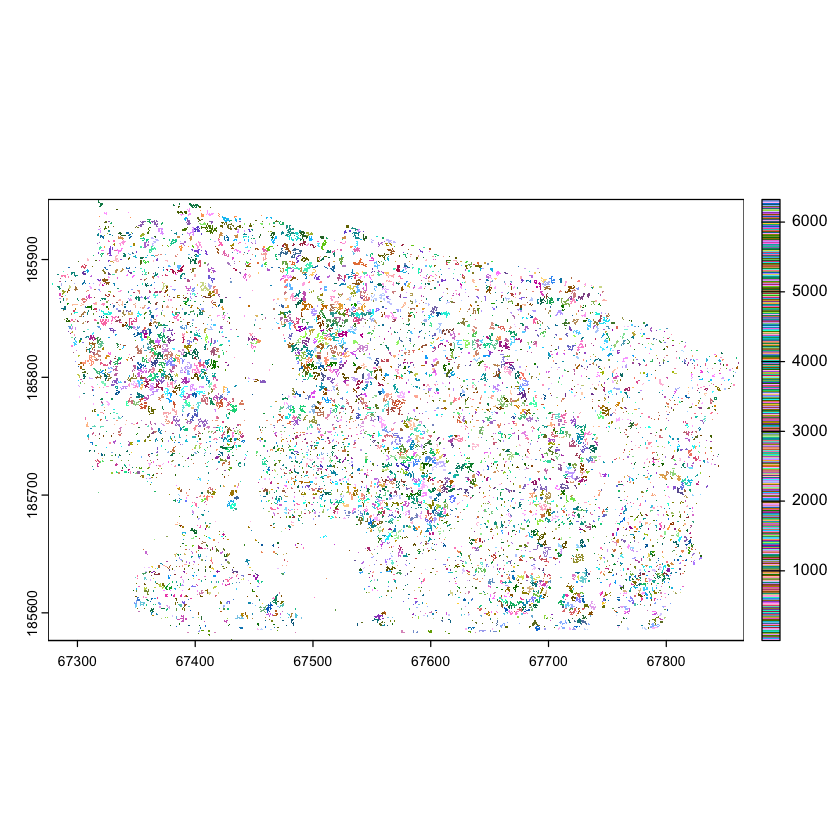

In [8]:
crowns <- algo()
plot(crowns, col = pastel.colors(1000))

## Package

In [ ]:
get_dsm <- function(inputfile,outputfolder=NULL){
    las <- readLAS(glue("{inputfile}"))
    st_crs(las) <- 6677
    mycsf <- csf(sloop_smooth = TRUE, class_threshold = 1, cloth_resolution = 1, time_step = 1)
    las <- classify(las, mycsf) 

    dtm_tin <- rasterize_terrain(las, res = 1, algorithm = tin())
    nlas <- las - dtm_tin

    if(!is.null(outputfolder)){
        writeLAS(nlas, glue("{outputfolder}/ndsm.las"))
    }

    return nlas
}
    

get_chm <- function(input_nlas, outputfolder = NULL){
    chm <- rasterize_canopy(nlas, res = 0.5, p2r(0.2, na.fill = tin()))
    linear_ws <- function(x) {x*0.1 + 3}
    ttops <- locate_trees(chm, lmf(linear_ws))

    algo <- dalponte2016(chm, ttops)
    nlas <- segment_trees(nlas, algo)

    # option for export of segmented chm
    if(!isnull(outputfolder)){
        writeLAS(nlas, glue("{outputfolder}/ndsm_segmented.las"))
    }

    return nlas
}

get_trees <- function(input_chm, outputfolder){
    trees <- filter_poi(nlas, !is.na(treeID))
    metrics <- tree_metrics(trees, ~list(z_max = max(Z)))
    metrics.sf = st_as_sf(metrics)

    # save to csv
    write.csv(metrics.sf, glue("{outputfolder}/tree_height.csv"))
}


## plotting

In [ ]:
nlas = readLAS("/Users/patricklucanas/Downloads/point_clouds/TakaneRiver/ndsm.las")
st_crs(nlas) <- 6677
chm_tin = rasterize_canopy(nlas, res = 0.5 , p2r(0.2, na.fill = NULL))
linear_ws <- function(x) {x*0.1 + 3}
ttops <- locate_trees(chm_tin, lmf(linear_ws))


In [ ]:
st_crs(ttops) <- 6677


algo <- dalponte2016(chm_tin, ttops)
crowns <- algo()
plot(crowns, col = pastel.colors(400))

In [ ]:
≈

In [ ]:
nlas <- segment_trees(nlas, algo)
trees <- filter_poi(nlas, !is.na(treeID))

# get max height of each tree
metrics <- tree_metrics(trees, ~list(z_max = max(Z)))
metrics.sf = st_as_sf(metrics)

# save to csv
write.csv(metrics.sf, glue("/Users/patricklucanas/Downloads/point_clouds/TakaneRiver/tree_height.csv"))

In [ ]:
writeLAS(trees, "/Users/patricklucanas/Downloads/point_clouds/TakaneRiver/trees.las")